
<a id='mc'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Cadeias Finitas de Markov

## Conteúdo

- [Cadeias Finitas de Markov](#Cadeias-Finitas-de-Markov)  
  - [Resumo](#Resumo)  
  - [Definições](#Definições)  
  - [Simulação](#Simulação)  
  - [Distribuições Marginais](#Distribuições-Marginais)  
  - [Irredutibilidade e Aperidiocidade](#Irredutibilidade-e-Aperiodicidade)  
  - [Distribuições Estacionárias](#Distribuições-Estacionárias)  
  - [Ergodicidade](#Ergodicidade)  
  - [Computando Expectativas](#Computando-Expectativas)  
  - [Exercícios](#Exercícios)  
  - [Soluções](#Soluções)  

> *Devidamente traduzido, revisado e adaptado pelos bolsistas CNPq Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob a supervisão do Prof. Christiano Penna, pesquisador do CAEN/UFC.*

## Resumo

As cadeias de Markov são uma das classes mais úteis de processos estocásticos, sendo:

- simples, flexível e suportado por muitos resultados teóricos elegantes  
- valioso para criar intuição sobre modelos dinâmicos aleatórios 
- central à modelagem quantitativa por direito próprio  


Você os encontrará em muitos modelos de economia e finanças.

Nesta aula, revisamos algumas das teorias das cadeias de Markov.

Também apresentaremos algumas das rotinas de alta qualidade para trabalhar com cadeias de Markov disponíveis no [QuantEcon.jl](http://quantecon.org/quantecon-jl).

Pré-requesito conhecimento prévio em probabilidade básica e álgebra linear.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true)

┌ Warning: On Windows, creating file symlinks requires Administrator privileges
└ @ Base.Filesystem file.jl:848


Activated C:\Users\cliente\Downloads\Project.toml
Info quantecon-notebooks-julia 0.4.0 activated, 0.5.0 requested


In [2]:
using LinearAlgebra, Statistics
using Distributions, Plots, Printf, QuantEcon, Random
gr(fmt = :png);

## Definições

Os seguintes conceitos são fundamentais.


<a id='finite-dp-stoch-mat'></a>

### Matrizes Estocásticas

<a id='index-2'></a>
Uma **matriz estocástica** (ou **matriz de Markov**)  é uma matriz quadrada $ P $ $ n \times n $ 
de tal modo que:

1. cada elemento de $ P $ é não negativo, e  
1. cada linha de $ P $ soma a um.


Cada linha de $ P $ pode ser considerada uma função de massa de probabilidade sobre $ n $ possíveis resultados.

Não é tão difícil verificar <sup><a href=#pm id=pm-link>[1]</a></sup> que se $ P $ é uma matriz estocástica, então é $ k $-ésima potência $ P^k $ para todo $ k \in \mathbb N $.

### Cadeias de Markov


<a id='index-4'></a>

Existe uma estreita conexão entre matrizes estocásticas e cadeias de Markov.

Para começar, deixe  $ S $ ser um conjunto finito com $ n $ elementos $ \{x_1, \ldots, x_n\} $.

O conjunto $ S $ é chamado de **espaço de estado** e $ x_1, \ldots, x_n $ são os **valores de estado**.

Uma **Cadeia de Markov** $ \{X_t\} $ em $ S $ é uma sequência de variáveis aleaórias em $ S $ que possuem a  **propriedade de Markov**.

Isso significa que, para qualquer data $ t $ e qualquer estado $ y \in S $,


<a id='equation-fin-markov-mp'></a>
$$
\mathbb P \{ X_{t+1} = y  \,|\, X_t \}
= \mathbb P \{ X_{t+1}  = y \,|\, X_t, X_{t-1}, \ldots \} \tag{1}
$$

Em outras palavras, conhecer o estado atual é suficiente para conhecer probabilidades para estados futuros.

Em particular, a dinâmica de uma cadeia de Markov é totalmente determinada pelo conjunto de valores


<a id='equation-mpp'></a>
$$
P(x, y) := \mathbb P \{ X_{t+1} = y \,|\, X_t = x \}
\qquad (x, y \in S) \tag{2}
$$

Por construção,

- $ P(x, y) $ é a probabilidade de ir de $ x $ para $ y $ em uma unidade de tempo (um passo)  
- $ P(x, \cdot) $ é a distribuição condicional $ X_{t+1} $ dado $ X_t = x $  


Podemos ver $ P $ como uma matriz estocástica onde:

$$
P_{ij} = P(x_i, x_j)
\qquad 1 \leq i, j \leq n
$$

Indo em outra direção, se tomamos a matriz estocástica $ P $, podemos gerar as cadeias de Markov $ \{X_t\} $ do seguinte modo:

- Pegue $ X_0 $ de alguma distribuição especificada 
- para cada $ t = 0, 1, \ldots $, pegue $ X_{t+1} $ de $ P(X_t,\cdot) $  


Por construção, o processo resultante satisfaz [(2)](#equation-mpp).


<a id='mc-eg1'></a>

### Exemplo 1

Considere um trabalhador que, a qualquer momento $ t $, está desempregado (estado 1) ou empregado (estado 2).

Suponha que, durante um período de um mês,

1. Um trabalhador desempregado encontra um emprego com probabilidade  $ \alpha \in (0, 1) $.  
1. Um trabalhador empregado perde o emprego e fica desempregado com probabilidade $ \beta \in (0, 1) $.  


Em termos do modelo de Markov, temos:

- $ S = \{ 1, 2\} $  
- $ P(1, 2) = \alpha $ e $ P(2, 1) = \beta $  


Podemos escrever as probabilidades de transição na forma de matriz como:

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

Quando tivermos os valores $ \alpha $ e $ \beta $,  podemos abordar uma série de perguntas, como:

- Qual é a duração média do desemprego?
- A longo prazo, que fração de tempo um trabalhador se encontra desempregado?  
- Dependendo do emprego, qual é a probabilidade de ficar desempregado pelo menos uma vez nos próximos 12 meses?  


Abordaremos esses aplicativos abaixo.

<a id='mc-eg2'></a>

### Exemplo 2

Usando dados de desemprego nos EUA, Hamilton [[Ham05]](https://julia.quantecon.org/../zreferences.html#hamilton2005) estimou a matriz estocástica

$$
P =
\left(
  \begin{array}{ccc}
     0.971 & 0.029 & 0 \\
     0.145 & 0.778 & 0.077 \\
     0 & 0.508 & 0.492
  \end{array}
\right)
$$

onde:

- a frequência é mensal 
- o primeiro estado representa “crescimento normal”  
- o segundo estado representa “recessão leve”  
- o terceiro estado representa “recessão grave”  


Por exemplo, a matriz nos diz que quando o estado estiver em crescimento normal, o estado voltará a crescer normalmente no próximo mês com probabilidade de 0,97.

Em geral, grandes valores na diagonal principal indicam persistência no processo $ \{ X_t \} $.

Esse processo de Markov também pode ser representado como um gráfico direcionado, com arestas rotuladas por probabilidades de transição

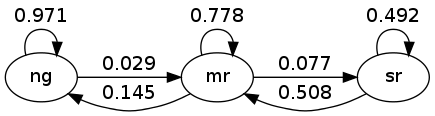
  
Aqui "ng" é um crescimento normal, "sr" é uma recessão leve etc.

## Simulação


<a id='index-5'></a>
Um jeito natural de responder essas questões sobre as cadeias de Markov é simulá-las.

(Para aproximar a probabilidade do evento $ E $, podemos simular várias vezes e contar a fração de vezes que $ E $ ocorre)

Existe uma funcionalidade interessante para simular cadeias de Markov no [QuantEcon.jl](http://quantecon.org/quantecon-jl).

- Eficiente, com muitas outras rotinas úteis para lidar com cadeias de Markov.  


No entanto, também é um bom exercício rolar nossas próprias rotinas - vamos fazer isso primeiro e depois voltar aos métodos no [QuantEcon.jl](http://quantecon.org/quantecon-jl).

Nestes exercícios, assumiremos o espaço de estado como  $ S = 1,\ldots, n $.

### Rodando o nosso próprio

Para simular uma cadeia de Markov, precisamos de sua matriz estocástica $ P $ e um estado inicial ou uma distribuição de probabilidade $ \psi $ para que o estado inicial seja extraido.

A cadeia de Markov é então construída como discutido acima. Repetir:

1. No momento $ t=0 $,  $ X_0 $ está definido para algum estado fixo ou escolhido dentre $ \psi $.  
1. A cada momento subsequente $ t $, o novo estado $ X_{t+1} $ é extraido de $ P(X_t, \cdot) $.  


Para implementar esse procedimento de simulação, precisamos de um método para gerar extrações a partir de distribuições discretas.

Para esta tarefa, usaremos uma variável categórica aleatória (ou seja, uma variável aleatória discreta com probabilidades atribuídas)

In [3]:
d = Categorical([0.5, 0.3, 0.2]) # 3 estados discretos
@show rand(d, 5)
@show supertype(typeof(d))
@show pdf(d, 1) # a probabilidade de está no estado 1
@show support(d)
@show pdf.(d, support(d)); # transmitir a fdp por todo o suporte

rand(d, 5) = [3, 1, 1, 2, 1]
supertype(typeof(d)) = Distribution{Univariate,Discrete}
pdf(d, 1) = 0.5
support(d) = Base.OneTo(3)
pdf.(d, support(d)) = [0.5, 0.3, 0.2]


Escreveremos nosso código como uma função que aceita os três argumentos a seguir:

- Uma matriz estocástica `P`  
- Um estado inicial `init`  
- Um número interio positivo `sample_size` que representa o comprimento da série temporal que a função deve retornar  

In [4]:
function mc_sample_path(P; init = 1, sample_size = 1000)
    @assert size(P)[1] == size(P)[2] # quadrado requerido
    N = size(P)[1] # deve está ao quadrado

    # Criar vector de RVs discretas para cada linha
    dists = [Categorical(P[i, :]) for i in 1:N]

    # configura a simulação
    X = fill(0, sample_size) # aloca memória ou zeros(Int64, sample_size)
    X[1] = init # configura o estado inicial

    for t in 2:sample_size
        dist = dists[X[t-1]] # obtém RV discreto da distribuição de transição do último estado 
        X[t] = rand(dist) # extrai o novo valor
    end
    return X
end

mc_sample_path (generic function with 1 method)

Vamos ver como isso funciona usando a matriz pequena:


<a id='equation-fm-smat'></a>
$$
P :=
\left(
  \begin{array}{cc}
     0.4 & 0.6  \\
     0.2 & 0.8
  \end{array}
\right) \tag{3}
$$

Como veremos mais adiante, para uma longa série `P`,  a fração da amostra que leva o valor 1 será de cerca de 0,25.

Se você executar o código a seguir, deverá obter aproximadamente essa resposta

In [5]:
P = [0.4 0.6; 0.2 0.8]
X = mc_sample_path(P, sample_size = 100_000); # nota 100_000 = 100000
μ_1 = count(X .== 1)/length(X) # .== teste de difusão para igualdade. Pode usar a média (X. == 1)

0.25154

### Usando as Rotinas do QuantEcon

Como acima discutido, [QuantEcon.jl](http://quantecon.org/quantecon-jl) possui rotinas para lidar com cadeias de Markov, incluindo simulação.

Aqui está uma ilustração usando o mesmo P do exemplo anterior.

In [6]:
P = [0.4 0.6; 0.2 0.8];
mc = MarkovChain(P)
X = simulate(mc, 100_000);
μ_2 = count(X .== 1)/length(X) # ou média(x -> x == 1, X)

0.24876

#### Adicionando valores de estado e condições iniciais

Se desejarmos, podemos fornecer uma especificação de valores de estado para `MarkovChain`.

Esses valores de estado podem ser números inteiros, flutuantes ou mesmo sequências de caracteres.

O código a seguir ilustra.

In [7]:
mc = MarkovChain(P, ["unemployed", "employed"])
simulate(mc, 4, init = 1) # começa no estado 1

4-element Array{String,1}:
 "unemployed"
 "employed"  
 "unemployed"
 "employed"  

In [8]:
simulate(mc, 4, init = 2) # começa no estado 2

4-element Array{String,1}:
 "employed"
 "employed"
 "employed"
 "employed"

In [9]:
simulate(mc, 4) # começa com a condição inicial escolhida aleatoriamente

4-element Array{String,1}:
 "employed"
 "employed"
 "employed"
 "employed"

In [10]:
simulate_indices(mc, 4)

4-element Array{Int64,1}:
 1
 2
 2
 2


<a id='mc-md'></a>

## Distribuições Marginais


<a id='index-7'></a>
Suppose that

1. $ \{X_t\} $ é uma cadeia de Markov com matriz estocástica $ P $  
1. a distribuição de $ X_t $ é conhecida por ser $ \psi_t $  


Qual é então a distribuição de $ X_{t+1} $, ou, mais geralmente, de $ X_{t+m} $?

### Solução

Deixe $ \psi_t $ ser a distribuição de $ X_t $ para $ t = 0, 1, 2, \ldots $.

Nosso primeiro objetivo é encontrar $ \psi_{t + 1} $ dado $ \psi_t $ e $ P $.

Para começar, escolha qualquer $ y  \in S $.

Usando a [lei da probabilidade total](https://en.wikipedia.org/wiki/Law_of_total_probability), podemos decompor a probabilidade de que $ X_{t+1} = y $ do seguinte modo:

$$
\mathbb P \{X_{t+1} = y \}
   = \sum_{x \in S} \mathbb P \{ X_{t+1} = y \, | \, X_t = x \}
               \cdot \mathbb P \{ X_t = x \}
$$

Em outra palavras, para obter a probabilidade de estar em $ y $ amanhã, explicamos todas as maneiras pelas quais isso pode acontecer e somamos suas probabilidades.

Reescrever esta afirmação em termos de probabilidades marginais e condicionais fornece.


<a id='mc-fdd'></a>
$$
\psi_{t+1}(y) = \sum_{x \in S} P(x,y) \psi_t(x)
$$

Existem $ n $ equações, uma para cada $ y \in S $.

Se pensarmos em $ \psi_{t+1} $ e $ \psi_t $ como *vetores de linhas* (como é tradicional nesta literatura), essas $ n $ equações são resumidas pela expressão da matriz.


<a id='mc-fddv'></a>

<a id='equation-fin-mc-fr'></a>
$$
\psi_{t+1} = \psi_t P \tag{4}
$$

Em outras palavras, para avançar a distribuição uma unidade de tempo, nós pós-multiplicamos por  $ P $.

Repetindo isso $ m $ vezes avançamos  $ m $ passos para o futuro

Portanto, iterando em [(4)](#equation-fin-mc-fr), a expressão $ \psi_{t+m} = \psi_t P^m $ também é válido —aqui $ P^m $ é a $ m $-ésima potência de $ P $.


<a id='mc-exfmar'></a>
Como um caso especial, podemos ver que se $ \psi_0 $ é a distribuição inicial a partir da qual $ X_0 $ é extraido, então $ \psi_0 P^m $ é a distribuição de
$ X_m $.

Isso é muito importante, então vamos repetir isso


<a id='equation-mdfmc'></a>
$$
X_0 \sim \psi_0 \quad \implies \quad X_m \sim \psi_0 P^m \tag{5}
$$

e, geralmente,


<a id='equation-mdfmc2'></a>
$$
X_t \sim \psi_t \quad \implies \quad X_{t+m} \sim \psi_t P^m \tag{6}
$$


<a id='finite-mc-mstp'></a>

### Probabilidades de Transição de Várias Etapas

Sabemos que a probabilidade de fazer a transição de $ x $ para $ y $ em um passo é $ P(x,y) $.

Acontece que a probabilidade de fazer a transição de $ x $ para $ y $ é
$ m $ passos é $ P^m(x,y) $, o $ (x,y) $-ésimo elemento de
$ m $-ésmima potência de $ P $.

Para ver a o porquê, considere novamente [(6)](#equation-mdfmc2), mas agora com $ \psi_t $ colocando toda a probabilidade no estado $ x $.

- 1 em $ x $-ésima posição e zero em outro lugar..  


Inserindo isso dentro [(6)](#equation-mdfmc2), podemos ver que, condicional em $ X_t = x $, a distribuição de $ X_{t+m} $ é a $ x $-ésima linha $ P^m $.

Em particular

$$
\mathbb P \{X_{t+m} = y \} = P^m(x, y) = (x, y) \text{-ésimo elemento de } P^m
$$

### Exemplo: Probabilidade de Recessão


<a id='index-8'></a>
Lembre-se da matriz estocástica $ P $ para recessão e crescimento [considerada acima](#mc-eg2).

Suponha que o estado atual é desconhecido — talvez as estatísticas estejam disponíveis apenas no *final* do mês atual.

Estimamos a probabilidade que a economia estar no estado $ x $ ser $ \psi(x) $.

A probabilidade de estar em recessão (leve ou grave) em 6 meses é dada pelo produto interno

$$
\psi P^6
\cdot
\left(
  \begin{array}{c}
     0 \\
     1 \\
     1
  \end{array}
\right)
$$


<a id='mc-eg1-1'></a>

### Exemplo 2: Distribuições transversais


<a id='index-9'></a>
As distribuições marginais que estudamos podem ser vistas como probabilidades ou como frequências transversais em grandes amostras.

Para ilustrar, lembre-se de nosso modelo de dinâmica de emprego / desemprego para um determinado trabalhador [discutido acima](#mc-eg1).

Considere uma grande população (ou seja, tendendo ao infinito) de trabalhadores, cada um cujas experiências de vida são descritas pela dinâmica especificada, independentemente uma da outra.

Deixe $ \psi $ ser a atual distribuição *transversal*  sobre $ \{ 1, 2 \} $.

- Por exemplo, $ \psi(1) $ é a taxa de desempregados.  


A distribuição transversal registra as frações de trabalhadores empregados e desempregados em um dado momento.

A mesma distribuição também descreve as frações da carreira de um trabalhador em particular gasta no emprego e no desemprego, respectivamente.

## Irredutibilidade e Aperiodicidade


<a id='index-11'></a>
Irredutibilidade e aperiodicidade são conceitos centrais da moderna teoria das cadeias de Markov.

Vamos ver do que se trata.

### Irredutibilidade

Deixe $ P $ ser uma matriz estocástica fixa

Dois estados $ x $ e $ y $ dizem que se **comunicam** comunicam entre si se existirem números interios positivos $ j $ e $ k $ de tal modo que

$$
P^j(x, y) > 0
\quad \text{e} \quad
P^k(y, x) > 0
$$

Em vista da discussão [acima](#finite-mc-mstp), isso significa precisamente que:

- Estado $ x $ pode ser alcançado eventualmente a partir do estado  $ y $, e  
- Estado $ y $ pode ser alcançado eventualmente a partir do estado  $ x $  


A matriz estocástica $ P $ é chamada de **irredutível** se todo os estados se comunicarem; que é, se $ x $ e $ y $ comunicar para todos
$ (x, y) $ em $ S \times S $.

Por exemplo, considere as seguintes probabilidades de transição para a riqueza de um conjunto fictício de famílias

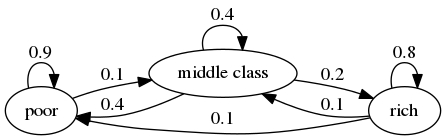

  
Podemos traduzir isso em uma matriz estocástica, colocando zeros onde não há arestas entre os nós.

$$
P :=
\left(
  \begin{array}{ccc}
     0.9 & 0.1 & 0 \\
     0.4 & 0.4 & 0.2 \\
     0.1 & 0.1 & 0.8
  \end{array}
\right)
$$

Está claro no gráfico que essa matriz estocástica é irredutível: podemos alcançar qualquer estado de qualquer outro estado eventualmente.

Nós também pode testar isso usando a classe de cadeias de Markov do [QuantEcon.jl](http://quantecon.org/quantecon-jl)

In [11]:
P = [0.9 0.1 0.0; 0.4 0.4 0.2; 0.1 0.1 0.8];
mc = MarkovChain(P)
is_irreducible(mc)

true

Aqui está um cenário mais pessimista, onde os pobres são pobres para sempre:

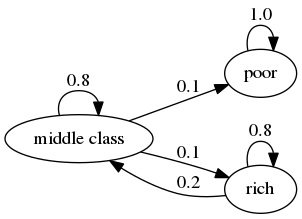
  
Essa matriz estocástica não é irredutível, pois, por exemplo, rico não é acessível a partir de pobres.

Vamos confirmar isso

In [12]:
P = [1.0 0.0 0.0; 0.1 0.8 0.1; 0.0 0.2 0.8];
mc = MarkovChain(P);
is_irreducible(mc)

false

Também podemos determinar as “classes de comunicação” ou os conjuntos de estados de comunicação (em que comunicação se refere a uma probabilidade diferente de zero de se mover em cada direção).

In [13]:
communication_classes(mc)

2-element Array{Array{Int64,1},1}:
 [1]   
 [2, 3]

Já deve estar claro para você que a irredutibilidade será importante em termos de resultados a longo prazo.

Por exemplo, a pobreza é uma sentença de prisão perpétua no segundo gráfico, mas não o primeiro.

Voltaremos a isso um pouco mais tarde.

### Aperiodicidade

Em termos gerais, uma cadeia de Markov é chamada de periódica se ela ciclar de uma maneira previsível e aperiódica de outra forma.

Aqui está um exemplo trivial com três estados:

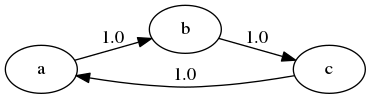

  
A cadeia circula com o período 3:

In [14]:
P = [0 1 0; 0 0 1; 1 0 0];
mc = MarkovChain(P);
period(mc)

3

Mais formalmente, o **período** de um estado $ x $ é o maior divisor comum do conjunto de números inteiros

$$
D(x) := \{j \geq 1 : P^j(x, x) > 0\}
$$

No último exemplo, $ D(x) = \{3, 6, 9, \ldots\} $ para todo estado $ x $, então o período é 3.

Uma matriz estocástica é chamada de **aperiódica** se o período de cada estado é 1, e **periódica** caso contrário.

Por exemplo, a matriz estocástica associada às probabilidades de transição abaixo é periódica porque, por exemplo, declara $ a $ tem período 2

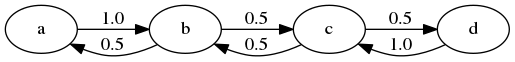
 
Podemos confirmar que a matriz estocástica é periódica da seguinte forma:

In [15]:
P = zeros(4, 4);
P[1, 2] = 1;
P[2, 1] = P[2, 3] = 0.5;
P[3, 2] = P[3, 4] = 0.5;
P[4, 3] = 1;
mc = MarkovChain(P);
period(mc)

2

In [16]:
is_aperiodic(mc)

false

## Distribuições Estacionárias


<a id='index-13'></a>
Como visto em [(4)](#equation-fin-mc-fr), podemos mudar as probabilidades para a frente uma unidade de tempo via pós-multiplicação por $ P $.

Algumas distribuições são invariantes nesse processo de atualização - por exemplo,

In [17]:
P = [.4 .6; .2 .8];
ψ = [0.25, 0.75];
ψ' * P

1×2 Adjoint{Float64,Array{Float64,1}}:
 0.25  0.75

Tais distribuições são chamadas **estacionárias** ou **invariantes**.

<a id='mc-stat-dd'></a>
Formalmente, uma distribuição $ \psi^* $ em $ S $ é chamada de **estacionária** para $ P $ se $ \psi^* = \psi^* P $.

A partir dessa igualdade, obtemos imediatamente  $ \psi^* = \psi^* P^t $ para todo $ t $.

Isso nos diz um fato importante: se a distribuição de  $ X_0 $ é uma distribuição estacionária, então $ X_t $ terá essa mesma distribuição para todo $ t $.

Portanto, as distribuições estacionárias têm uma interpretação natural como estados estacionários estocásticos - discutiremos isso mais em um momento.

Matematicamente, uma distribuição estacionária é um ponto fixo de $ P $ quando $ P $ é pensado como o mapa $ \psi \mapsto \psi P $ de (linhas) vetores para (linhas) vetores.

**Teorema.** Toda matriz estocástica $ P $ tem pelo menos uma distribuição estacionária.

(Estamos assumindo aqui que o espaço de estado  $ S $ é finito; e não forem necessárias mais suposições)

Para uma prova desse resultado você pode aplicar o [teorema do ponto fixo de Brouwer](https://en.wikipedia.org/wiki/Brouwer_fixed-point_theorem), ou ver [EDTC](http://johnstachurski.net/edtc.html), teorema 4.3.5.

De fato, pode haver muitas distribuições estacionárias correspondentes a uma dada matriz estocástica P $ P $.

- Por exemplo, se $ P $ é a matriz de identidade, todas as distribuições são estacionárias.


Como distribuições estacionárias são equilíbrios de longo prazo, para obter exclusividade, exigimos que as condições iniciais não sejam infinitamente persistentes.

A persistência infinita das condições iniciais ocorre se determinadas regiões do espaço de estados não puderem ser acessadas de outras regiões, que é o oposto da irredutibilidade.

Isso dá alguma intuição para o seguinte teorema fundamental.


<a id='mc-conv-thm'></a>
**Teorema.** Se $ P $ é ambos, periódico e irredutível, então

1. $ P $ tem exatamente uma distribuição estacionária $ \psi^* $.  
1. Para qualquer distribuição inicial $ \psi_0 $, temos $ \| \psi_0 P^t - \psi^* \| \to 0 $ como $ t \to \infty $.  


Para uma prova, veja, por exemplo, o teorema 5.2 de [[Haggstrom02]](https://julia.quantecon.org/../zreferences.html#haggstrom2002finite).

(Observe que a parte 1 do teorema requer apenas irredutibilidade, enquanto a parte 2 requer irredutibilidade e aperiodicidade)

Uma matriz estocástica que satisfaz as condições do teorema é às vezes chamada de **uniforme ergódica**.

Uma condição suficientemente fácil para a aperiodicidade e a irredutibilidade é que todo elemento de $ P $ é estritamente positivo

- Tente se convencer disso  

### Exemplo

Lembre-se do nosso modelo de dinâmica de emprego / desemprego para um determinado trabalhador [discutido acima](#mc-eg1).

Assumindo $ \alpha \in (0,1) $ e $ \beta \in (0,1) $, a condição de ergodicidade uniforme é satisfeita

Deixe $ \psi^* = (p, 1-p) $ seja a distribuição estacionária, então $ p $ corresponde ao desemprego (estado 1).

Usando $ \psi^* = \psi^* P $ e um pouco de álgebra rende

$$
p = \frac{\beta}{\alpha + \beta}
$$

Esta é, em certo sentido, uma probabilidade estável de desemprego - mais sobre a interpretação abaixo.

Não surpreendentemente, ele tende a zero como  $ \beta \to 0 $, e para um como $ \alpha \to 0 $.

### Calculando Distribuições Estacionárias


<a id='index-14'></a>
Como discutido acima, uma dada matriz de Markov $ P $ pode ter muitas distribuições estacionárias

Ou seja, pode haver muitos vetores de linha s $ \psi $ tal que $ \psi = \psi P $.

Em fato se $ P $ possui duas distintas distribuições estacionárias $ \psi_1,
\psi_2 $ então ele tem infinitamente muitos, pois nesse caso, como você pode verificar,


$$
\psi_3 := \lambda \psi_1 + (1 - \lambda) \psi_2
$$

é uma distribuição estacionária para  $ P $ para qualquer $ \lambda \in [0, 1] $.

Se restringirmos a atenção ao caso em que apenas uma distribuição estacionária existe, uma opção para encontrá-la é tentar resolver o sistema linear $ \psi (I_n - P) = 0 $ para $ \psi $, onde $ I_n $ é a identidade $ n \times n $.

Mas o vetor zero resolve esta equação.

Portanto, precisamos impor a restrição de que a solução deve ser uma distribuição de probabilidade.

Um algoritmo adequado é implementado no [QuantEcon.jl](http://quantecon.org/quantecon-jl) — o próximo bloco de código ilustra

In [18]:
P = [.4 .6; .2 .8];
mc = MarkovChain(P);
stationary_distributions(mc)

1-element Array{Array{Float64,1},1}:
 [0.25, 0.7499999999999999]

A distribuição estacionária é única.

### Convergência para Estacionáriedade


<a id='index-15'></a>
A parte 2 do teorema da convergência em cadeia de Markov [iniciado acima](#mc-conv-thm) afirma que a distribuição de $ X_t $ converge para a distribuição estacionária, independentemente de onde começamos.

Isso adiciona um peso considerável à nossa interpretação de  $ \psi^* $ como um estado estacionário estocástico.

A convergência no teorema é ilustrada na próxima figura

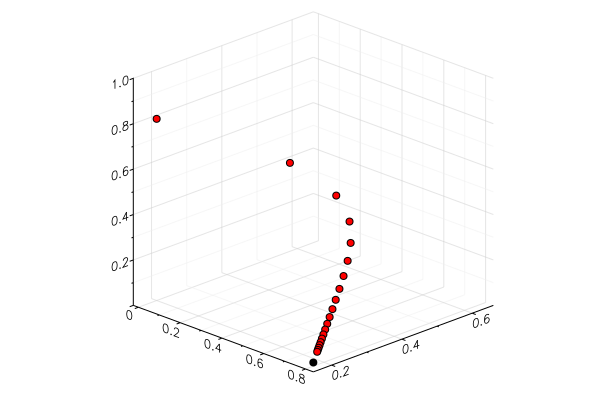

In [19]:
P = [0.971 0.029 0.000
     0.145 0.778 0.077
     0.000 0.508 0.492] # matriz estocástica

ψ = [0.0 0.2 0.8] # distribuição inicial

t = 20 # comprimento
x_vals = zeros(t)
y_vals = similar(x_vals)
z_vals = similar(x_vals)
colors = [repeat([:red], 20); :black] # para o plot

for i in 1:t
    x_vals[i] = ψ[1]
    y_vals[i] = ψ[2]
    z_vals[i] = ψ[3]
    ψ = ψ * P # atualizar distribuição
end

mc = MarkovChain(P)
ψ_star = stationary_distributions(mc)[1]
x_star, y_star, z_star = ψ_star # descompacta o dist estacionário
plt = scatter([x_vals; x_star], [y_vals; y_star], [z_vals; z_star], color = colors,
              gridalpha = 0.5, legend = :none)
plot!(plt, camera = (45,45))

Aqui

- $ P $ é a matriz estocástica para recessão e crescimento [considerado acima](#mc-eg2)  
- O ponto vermelho mais alto é uma distribuição de probabilidade inicial escolhida arbitrariamente   $ \psi $, representada como um vetor em $ \mathbb R^3 $  
- Os outros pontos vermelhos são as distribuições $ \psi P^t $ para $ t = 1, 2, \ldots $  
- O ponto preto é $ \psi^* $  


O código para a figura pode ser encontrado [aqui](https://github.com/QuantEcon/QuantEcon.lectures.code/blob/master/finite_markov/mc_convergence_plot.jl) — você pode tentar experimentar diferentes condições iniciais.

<a id='ergodicity'></a>

## Ergodicidade


<a id='index-17'></a>
Sob irredutibilidade, outro resultado importante é obtido: Para todos os $ x \in S $,


<a id='equation-llnfmc0'></a>
$$
\frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = x\}  \to \psi^*(x)
    \quad \text{as } m \to \infty \tag{7}
$$

Aqui

- $ \mathbf{1}\{X_t = x\} = 1 $ se $ X_t = x $ e zero caso contrario  
- convergência é com probabilidade um
- o resultado não depende da distribuição (ou valor) de $ X_0 $  


O resultado nos diz que a fração de tempo que a cadeia passa no estado $ x $ converge para $ \psi^*(x) $ como o tempo vai para o infinito.


<a id='new-interp-sd'></a>
Isso nos dá outra maneira de interpretar a distribuição estacionária - desde que o resultado da convergência em [(7)](#equation-llnfmc0) seja válido.

A convegência em [(7)](#equation-llnfmc0) é um caso especial de uma lei de grande número de resultados para cadeias de Markov - veja [EDTC](http://johnstachurski.net/edtc.html), seção 4.3.4 para obter mais informações.


<a id='mc-eg1-2'></a>

### Exemplo

Lembre-se de nossa interpretação transversal do modelo de emprego / desemprego [discutido acima](#mc-eg1-1).

Assuma que $ \alpha \in (0,1) $ e $ \beta \in (0,1) $, para que a irredutibilidade e a aperiodicidade sejam válidas.

Vimos que a distribuição estacionária é  $ (p, 1-p) $, onde

$$
p = \frac{\beta}{\alpha + \beta}
$$

Na interpretação transversal, essa é a fração de pessoas desempregadas.

Em vista do nosso último resultado (ergodicidade), é também a fração de tempo que um trabalhador pode esperar gastar desempregado.

Assim, a longo prazo, médias transversais para uma população e médias de séries temporais para uma determinada pessoa coincidem.

Essa é uma interpretação da noção de ergodicidade.

<a id='finite-mc-expec'></a>

## Computando Expectativas


<a id='index-18'></a>
Estamos interessados em calcular as expectativas da forma


<a id='equation-mc-une'></a>
$$
\mathbb E [ h(X_t) ] \tag{8}
$$

e expectativas condicionais, como


<a id='equation-mc-cce'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x] \tag{9}
$$

Onde

- $ \{X_t\} $ é uma cadeia de Markov gerada por uma matriz estocástica $ P $ $ n \times n $ 
- $ h $ é uma função dada que, nas expressões que envolvem álgebra matricial, consideraremos o vetor da coluna 

$$
h
= \left(
\begin{array}{c}
    h(x_1) \\
    \vdots \\
    h(x_n) \\
\end{array}
  \right)
$$

A expactativa incondicional [(8)](#equation-mc-une) é fácil: apenas somamos a distribuição de  $ X_t $ para obter

$$
\mathbb E [ h(X_t) ]
= \sum_{x \in S} (\psi P^t)(x) h(x)
$$

Aqui $ \psi $ é a distribuiçãod de $ X_0 $.

Desde $ \psi $ e portanto $ \psi P^t $ são vetores linhas, podemos escrever isso como

$$
\mathbb E [ h(X_t) ]
=  \psi P^t h
$$

Para a expectativa condicional [(9)](#equation-mc-cce), precisamos somar a distribuição condicional de  $ X_{t + k} $ dado $ X_t = x $.

Nós já sabemos que isso é  $ P^k(x, \cdot) $, então


<a id='equation-mc-cce2'></a>
$$
\mathbb E [ h(X_{t + k})  \mid X_t = x]
= (P^k h)(x) \tag{10}
$$

O vetor $ P^k h $ armazena a expectativa condicional $ \mathbb E [ h(X_{t + k})  \mid X_t = x] $ sobre todo $ x $.

### Expectativas de Somas Geométricas

Às vezes, também queremos calcular expectativas de uma soma geométrica, como
$ \sum_t \beta^t h(X_t) $.

Em vista da discussão anterior, isto é

$$
\mathbb{E} \left[
        \sum_{j=0}^\infty \beta^j h(X_{t+j}) \mid X_t = x
    \right]
= [(I - \beta P)^{-1} h](x)
$$

Onde

$$
(I - \beta P)^{-1}  = I + \beta P + \beta^2 P^2 + \cdots
$$

Pré-multiplicação por  $ (I - \beta P)^{-1} $ equivale a “aplicar o **operador resolvente**”.

## Exercícios


<a id='mc-ex1'></a>

### Exercício 1

De acordo com o discutido [acima](#mc-eg1-2), se a dinâmica de emprego de um trabalhador obedece à matriz estocástica

$$
P
= \left(
\begin{array}{cc}
    1 - \alpha & \alpha \\
    \beta & 1 - \beta
\end{array}
  \right)
$$

com $ \alpha \in (0,1) $ e $ \beta \in (0,1) $, então, a longo prazo, a fração do tempo gasto em desempregados será


$$
p := \frac{\beta}{\alpha + \beta}
$$

Em outras palavras, se $ \{X_t\} $ representa a cadeia de Markov para empregados, então $ \bar X_m \to p $ como $ m \to \infty $, onde

$$
\bar X_m := \frac{1}{m} \sum_{t = 1}^m \mathbf{1}\{X_t = 1\}
$$

Seu exercício é ilustrar essa convergência

Primeiro,

- gere uma série temporal simulada  $ \{X_t\} $ de comprimento 10,000, começando em $ X_0 = 1 $  
- plote $ \bar X_m - p $ contra $ m $, onde $ p $ é como definido acima  


Segundo, repita o primeiro passo, mas desta vez usando $ X_0 = 2 $.

Em ambos os casos, defina $ \alpha = \beta = 0.1 $.

O resultado deve se parecer com o seguinte - aleatoriedade do módulo, é claro

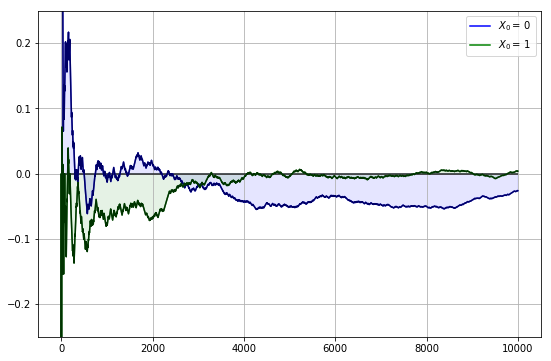

  
(Você não precisa adicionar toques sofisticados ao gráfico - veja a solução se estiver interessado)


<a id='mc-ex2'></a>

### Exercício 2

Um tópico de interesse para a economia e muitas outras disciplinas é o *ranking*.

Vamos agora considerar um dos problemas de classificação mais práticos e importantes - a classificação atribuída às páginas da Web pelos mecanismos de pesquisa.

(Embora o problema seja motivado de fora da economia, existe de fato uma conexão profunda entre os sistemas de classificação de busca e os preços em certos equilíbrios competitivos - veja [[DLP13]](https://julia.quantecon.org/../zreferences.html#dlp2013))

Para entender o problema, considere o conjunto de resultados retornados por uma consulta para um mecanismo de pesquisa na web.

Para o usuário, é desejável

1. receber um grande conjunto de correspondências precisas 
1. ter as correspondências retornadas em ordem, onde a ordem corresponde a alguma medida de "importância"

A classificação de acordo com uma medida de importância é o problema que agora consideramos.

A metodologia desenvolvida para resolver esse problema pelos fundadores do Google, Larry Page e Sergey Brin, é conhecida como [PageRank](https://en.wikipedia.org/wiki/PageRank).

Para ilustrar a ideia, considere o seguinte diagrama

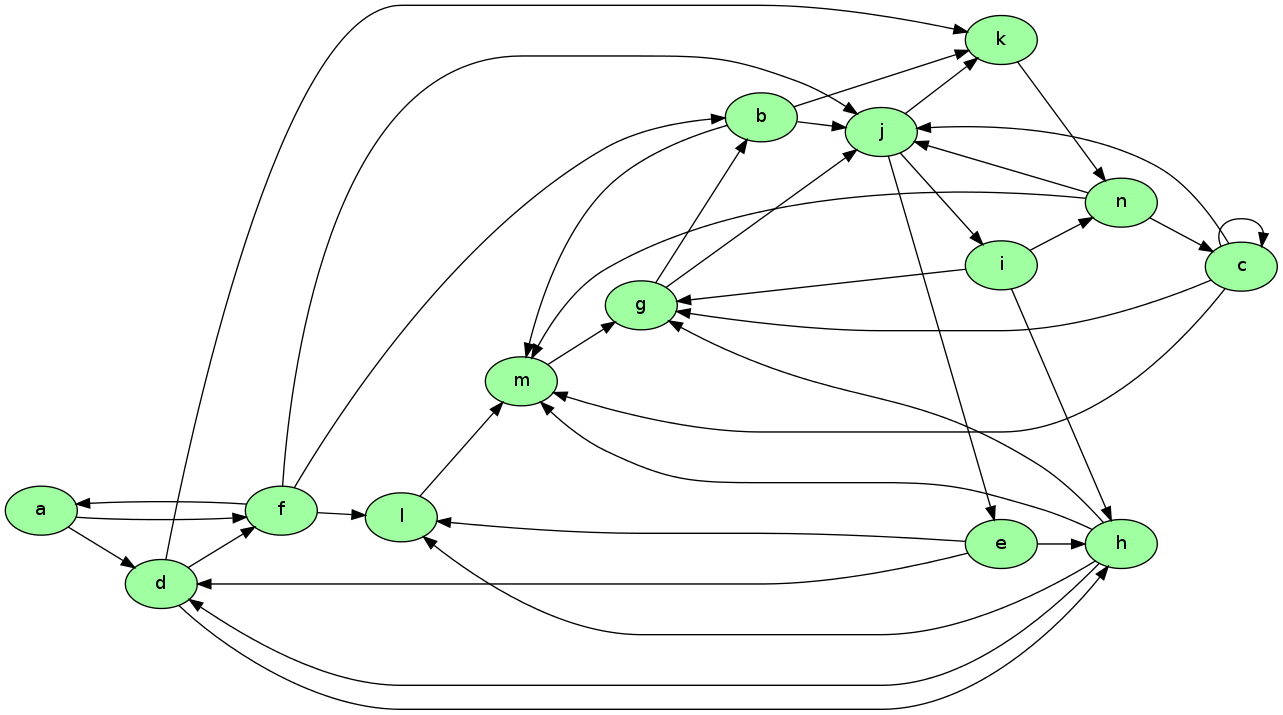
  
Imagine que esta é uma versão em miniatura da WWW, com

- cada nó representando uma página da web  
- cada seta representa a existência de um link de uma página para outra


Agora, vamos pensar em quais páginas provavelmente são importantes, no sentido de serem valiosas para um usuário de mecanismo de pesquisa.

Um critério possível para a importância de uma página é o número de links de entrada - uma indicação de popularidade.

Por essa medida `m` e `j` são as páginas mais importantes, com 5 links de entrada cada.

No entanto, e se as páginas com links para `m`, por exemplo, não forem importantes?

Pensando dessa maneira, parece apropriado ponderar os nós de entrada por importância relativa.

O algoritmo PageRank faz exatamente isso.

Uma apresentação ligeiramente simplificada que captura a ideia básica é a seguinte.

Deixando $ j $ ser (o índice inteiro) de uma página típica $ r_j $ ser seu ranking, estabelecemos

$$
r_j = \sum_{i \in L_j} \frac{r_i}{\ell_i}
$$

onde

- $ \ell_i $ é o total de links de saida de $ i $  
- $ L_j $ é o conjunto de todas as páginas $ i $ tal que $ i $ tem um link para $ j $  


Essa é uma medida do número de links de entrada, ponderado por sua própria classificação (e normalizado por  $ 1 / \ell_i $).

Há, no entanto, outra interpretação, e ela nos leva de volta às cadeias de Markov.

Deixe $ P $ ser a matriz dada por $ P(i, j) = \mathbf 1\{i \to j\} / \ell_i $ onde $ \mathbf 1\{i \to j\} = 1 $ se $ i $ possui um link para $ j $ e zero caso contrario

A matriz $ P $ é uma matriz estocástica, desde que cada página tenha pelo menos um link.

Com esta definição de $ P $ temos

$$
r_j
= \sum_{i \in L_j} \frac{r_i}{\ell_i}
= \sum_{\text{todo } i} \mathbf 1\{i \to j\} \frac{r_i}{\ell_i}
= \sum_{\text{todo } i} P(i, j) r_i
$$

Escrevendo $ r $ para o vetor de linha das classificações, isso se torna $ r = r P $.

Logo $ r $ é a distribuição estacionária da matriz estocástica $ P $.

Vamos pensar em $ P(i, j) $ como a probabilidade de mudar da "página" $ i $ para página $ j $.

O valor $ P(i, j) $ tem a interpretação

- $ P(i, j) = 1/k $ se $ i $ possui $ k $ links de saída, e $ j $ é um deles 
- $ P(i, j) = 0 $ se $ i $ não tem nenhum link direto para $ j $  


Assim, o movimento de página para página é o de um internauta que se move de uma página para outra clicando aleatoriamente em um dos links dessa página.

Aqui, “aleatório” significa que cada link é selecionado com igual probabilidade.

Visto que $ r $ é a distribuição estacionária de $ P $, assumindo que a condição de uniforme ergodicidade é válida, [podemos interpretar](#new-interp-sd) $ r_j $ como a fração de tempo que um surfista aleatório (muito persistente) gasta na página $ j $.

Seu exercício é aplicar esse algoritmo de classificação ao gráfico mostrado acima e retornar a lista de páginas ordenadas por classificação.

Ao resolver o ranking, você descobrirá que o nó com a classificação mais alta é de fato `g`, enquanto o mais baixo é `a`.


<a id='mc-ex3'></a>

### Exercício 3

A trabalho numérico, às vezes é conveniente substituir um modelo contínuo por um modelo discreto.

Em particular, cadeias de Markov são rotineiramente geradas como aproximações discretas aos processos AR (1) da forma

$$
y_{t+1} = \rho y_t + u_{t+1}
$$

Aqui $ {u_t} $ é assumido ser i.i.d. e $ N(0, \sigma_u^2) $.

A variação da distribuição de probabilidade estacionária de $ \{ y_t \} $ is

$$
\sigma_y^2 := \frac{\sigma_u^2}{1-\rho^2}
$$

O método Tauchen [[Tau86]](https://julia.quantecon.org/../zreferences.html#tauchen1986) é o método mais comum para aproximar esse processo de estado contínuo com uma cadeia de Markov de estado finito.

Uma rotina para isso já existe no [QuantEcon.jl](http://quantecon.org/quantecon-jl) mas vamos escrever nossa própria versão como um exercício.

Como primeiro passo, escolhemos

- $ n $, o número de estados para a aproximação discreta
- $ m $, um número inteiro que parametriza a largura do espaço de estado  


Em seguida, criamos um espaço de estado $ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $
e uma matriz estocástica $ P $ $ n \times n $ de tal modo que

- $ x_0 = - m \, \sigma_y $  
- $ x_{n-1} = m \, \sigma_y $  
- $ x_{i+1} = x_i + s $ onde $ s = (x_{n-1} - x_0) / (n - 1) $  


Deixe $ F $ Fser a função de distribuição cumulativa da distribuição normal $ N(0, \sigma_u^2) $.

Os valores $ P(x_i, x_j) $ são calculados para aproximar o processo AR (1) - omitindo a derivação, as regras são as seguintes:

1. Se $ j = 0 $, e defina  


$$
P(x_i, x_j) = P(x_i, x_0) = F(x_0-\rho x_i + s/2)
$$

1. Se $ j = n-1 $, e defina 


$$
P(x_i, x_j) = P(x_i, x_{n-1}) = 1 - F(x_{n-1} - \rho x_i - s/2)
$$

1. Caso contrario, defina


$$
P(x_i, x_j) = F(x_j - \rho x_i + s/2) - F(x_j - \rho x_i - s/2)
$$

O exercício é para escrever a função `approx_markov(rho, sigma_u, m = 3, n = 7)` que retorne
$ \{x_0, \ldots, x_{n-1}\} \subset \mathbb R $ e a matriz $ P $ $ n \times n $ como descrito acima

- Melhor ainda, escreva uma função que retorne uma instância do tipo MarkovChain  do [QuantEcon.jl](http://quantecon.org/quantecon-jl).

## Soluções

### Exercício 1

Calcule a fração do tempo que o trabalhador gasta desempregado e compare-a com a probabilidade estacionária.

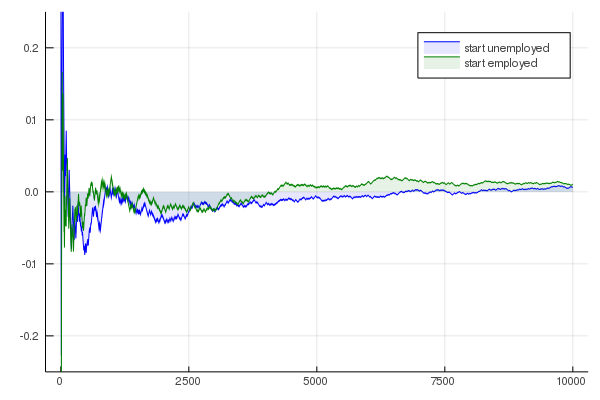

In [20]:
α = 0.1 # probabilidade de ser contratado
β = 0.1 # probabilidade de ser demitido
N = 10_000
p̄ = β / (α + β) # probabilidades do estado estacionário
P = [1 - α   α
     β   1 - β] # matriz estocástica
mc = MarkovChain(P)
labels = ["start unemployed", "start employed"]
y_vals = Array{Vector}(undef, 2) # suporte de caminhos de amostra

for x0 in 1:2
    X = simulate_indices(mc, N; init = x0) # gera o caminho da amostra 
    X̄ = cumsum(X .== 1) ./ (1:N) # fração do estado de computação. ./ necessário para precedência 
    y_vals[x0] = X̄ .- p̄ # diferencia a plotagem do estado estacionário
end

plot(y_vals, color = [:blue :green], fillrange = 0, fillalpha = 0.1,
     ylims = (-0.25, 0.25), label = reshape(labels, 1, length(labels)))

### Exercise 2

In [21]:
web_graph_data = sort(Dict('a' => ['d', 'f'],
                           'b' => ['j', 'k', 'm'],
                           'c' => ['c', 'g', 'j', 'm'],
                           'd' => ['f', 'h', 'k'],
                           'e' => ['d', 'h', 'l'],
                           'f' => ['a', 'b', 'j', 'l'],
                           'g' => ['b', 'j'],
                           'h' => ['d', 'g', 'l', 'm'],
                           'i' => ['g', 'h', 'n'],
                           'j' => ['e', 'i', 'k'],
                           'k' => ['n'],
                           'l' => ['m'],
                           'm' => ['g'],
                           'n' => ['c', 'j', 'm']))

OrderedCollections.OrderedDict{Char,Array{Char,1}} with 14 entries:
  'a' => ['d', 'f']
  'b' => ['j', 'k', 'm']
  'c' => ['c', 'g', 'j', 'm']
  'd' => ['f', 'h', 'k']
  'e' => ['d', 'h', 'l']
  'f' => ['a', 'b', 'j', 'l']
  'g' => ['b', 'j']
  'h' => ['d', 'g', 'l', 'm']
  'i' => ['g', 'h', 'n']
  'j' => ['e', 'i', 'k']
  'k' => ['n']
  'l' => ['m']
  'm' => ['g']
  'n' => ['c', 'j', 'm']

In [22]:
nodes = keys(web_graph_data)
n = length(nodes)
# cria matriz de links adjacente (Q [i, j] = verdadeiro para link, falso caso contrário) 
Q = fill(false, n, n)
for (node, edges) in enumerate(values(web_graph_data))
    Q[node, nodes .∈ Ref(edges)] .= true
end

# cria a matriz estocástica correspondente 
P = Q ./ sum(Q, dims = 2)

mc = MarkovChain(P)
r = stationary_distributions(mc)[1] # dsitribuição estacionária
ranked_pages = Dict(zip(keys(web_graph_data), r)) # detentor de resultados

# imprime as soluções
println("Rankings\n ***")
sort(collect(ranked_pages), by = x -> x[2], rev = true) # impressão classificada

Rankings
 ***


14-element Array{Pair{Char,Float64},1}:
 'g' => 0.16070778858515053 
 'j' => 0.15936158342833578 
 'm' => 0.119515123584059   
 'n' => 0.10876973827831275 
 'k' => 0.0910628956751643  
 'b' => 0.0832646081451476  
 'e' => 0.05312052780944526 
 'i' => 0.05312052780944526 
 'c' => 0.04834210590147233 
 'h' => 0.04560118369030004 
 'l' => 0.032017852378295776
 'd' => 0.030562495452009602
 'f' => 0.011642855410289372
 'a' => 0.002910713852572343

### Exercício 3

A solução do [QuantEcon.jl](https://github.com/QuantEcon/QuantEcon.jl) pode ser encontrada [aqui](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/markov/markov_approx.jl).


**Nota de rodapé**

<p><a id=pm href=#pm-link><strong>[1]</strong></a> Dica: primeiro mostre que se $ P $ e $ Q $ então o mesmo ocorre com seus produtos - para verificar as somas de linha, tente pós-multiplicar por um vetor de coluna de uma. Finalmente, argumente que $ P^n $ é uma matriz estocástica usando indução.